## <Telco Customer Churn – Exploratory Data Analysis (EDA)>
- 본 노트북은 Streamlit 대시보드 구현에 앞서, 고객 이탈 요인 탐색 및 시각화 방향성을 도출하기 위한 EDA 문서입니다
- 본 분석은 **모델링 목적이 아닌, 인사이트 도출 중심의 탐색적 분석**입니다.
- 분석 대상 데이터는 운영 DB(MySQL)에 적재된 데이터 기준과 동일한 범위를 사용합니다.
- 동일한 데이터 전처리 기준은 Streamlit 대시보드에서도 그대로 사용됩니다.  

본 EDA는 고객 이탈에 영향을 미치는 주요 요인을 탐색하고, 비즈니스 관점에서 의사결정에 활용 가능한  인사이트를 도출하는 데 초점을 둡니다.  
  
이후 SQL + Python 분석 노트북에서는 운영 DB 기반 SQL 분석과 EDA 결과를 종합하여,  
이탈 위험 세그먼트를 KPI 관점에서 재정의·검증합니다.


### 1. 문제 정의 및 핵심 KPI 설정
본 분석의 목적은 Telco 고객 데이터 기반으로 **고객 이탈(Churn)을 유발하는 핵심 요인을 탐색**하고,  
이탈 가능성이 높은 고객 세그먼트를 탐색적으로 식별하는 데 있습니다.

EDA 전반에서는 아래의 KPI를 기준선으로 사용합니다.
- 전체 고객 수(Total Customers)
- 이탈 고객 수(Churn Customers)
- 이탈률(Churn Rate)

해당 KPI는 **운영 DB(MySQL) 기준 고객 데이터**를 기반으로 해석합니다.

### 2. 데이터 로드 및 데이터 구조 검증

In [2]:
import pandas as pd

df_raw = pd.read_csv("../data/telco_churn.csv")
df_raw.shape

(7043, 21)

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### 2-1. TotalCharges 컬럼 타입 확인 및 정제

In [4]:
df_raw['TotalCharges'] = pd.to_numeric(
    df_raw['TotalCharges'],
    errors='coerce'
)

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df_raw.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

`TotalCharges` 컬럼은 문자열 형태로 저장되어 있었으며, 숫자 변환 과정에서 일부 NaN이 발생했습니다.  

해당 NaN은 **신규 고객(tenure = 0)**의 누적 요금이 빈 문자열로 저장된 경우에 해당합니다.

#### 2-2. 분석 대상 데이터 기준 정합성

본 EDA에서는 **Streamlit 대시보드 및 KPI 분석 결과와의 데이터 일관성**을 위해  
`TotalCharges`값이 존재하는 고객만을 분석 대상으로 설정합니다.  
이는 `TotalCharges` 타입 변환이 불가능한 일부 행(11건)이 DB 적재 과정에서 제외되었기 때문입니다.  

- CSV 원본 데이터: 7,043명
- 분석 대상 데이터: 7,032명

본 EDA에서 사용한 데이터는 이후 SQL 분석 및 Streamlit 대시보드에서 사용하는  
운영 DB 데이터와 동일한 전처리 기준을 따릅니다.

In [6]:
df = df_raw.dropna(subset=['TotalCharges']).copy()
df.shape

(7032, 21)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 
 17  

In [8]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### 3. 타겟 변수(Churn) 분포 확인
본 섹션부터의 모든 이탈률 해석은   
운영 DB 기준 KPI(7,032명)를 기준선으로 사용합니다.

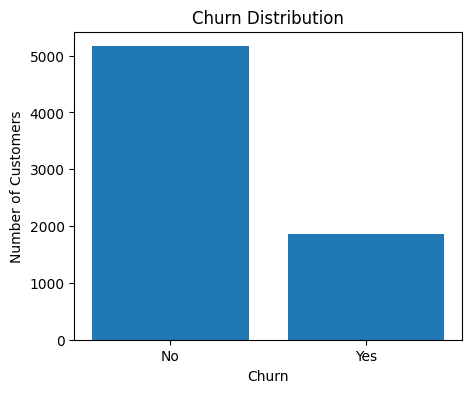

In [9]:
import matplotlib.pyplot as plt

churn_counts = df['Churn'].value_counts()

plt.figure(figsize=(5, 4))
plt.bar(churn_counts.index, churn_counts.values)
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Number of Customers")
plt.show()

**결과 해석**  
- **`Churn`은 Yes / No의 이진 변수**임
- 이탈 고객보다 유지 고객의 비중이 더 높은 클래스 불균형 구조
- 이러한 분포 특성을 고려하여, 이후 분석에서는 **이탈 고객(Churn=Yes)**을 중심으로 패턴을 해석함

### 4. 핵심 변수 후보 탐색 (Churn 기준)
고객 이탈은 **"사용 기간 -> 비용 부담 -> 서비스 구조"** 가 누적된 결과로 해석할 수 있습니다.  

본 EDA에서는 단변량 기준 이탈 설명력이 낮고,  
비즈니스 해석 기여도가 제한적인 변수는 심층 분석에서 제외했습니다.
- gender
- PhoneService
- MultipleLines  

이는 모델링 목적이 아닌, **비즈니스 관점에서 의미 있는 변수 해석에 집중하기 위함**입니다.

#### 4-1. 시간 기반 변수: Tenure
- 고객 이탈을 설명하는 가장 강력한 선행 지표
- 신규 고객과 장기 고객 간 이탈 패턴 비교 가능

<Figure size 600x400 with 0 Axes>

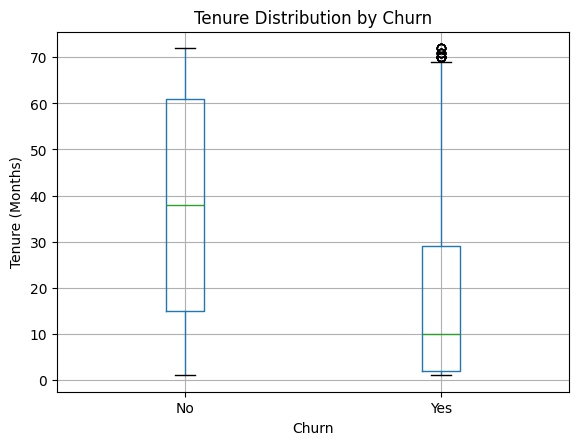

In [10]:
plt.figure(figsize=(6,4))
df.boxplot(column='tenure', by='Churn')
plt.title("Tenure Distribution by Churn")
plt.suptitle("")
plt.xlabel("Churn")
plt.ylabel("Tenure (Months)")
plt.show()

**결과 해석**
- 이탈 고객은 비이탈 고객에 비해 전반적으로 짧은 계약 기간을 보임
- 특히 `tenure`가 낮은 구간에서 이탈 고객이 집중되어, 신규 고객 이탈 관리의 중요성을 시사함

#### 4-2. 비용 기반 변수: MonthlyCharges / TotalCharges
- 고객이 체감하는 서비스 대비 비용 부담을 나타내는 지표
- tenure 이후, 이탈을 유발하는 요인으로 작용 가능

(1) 월 요금(MonthlyCharges) 분포 비교

<Figure size 600x400 with 0 Axes>

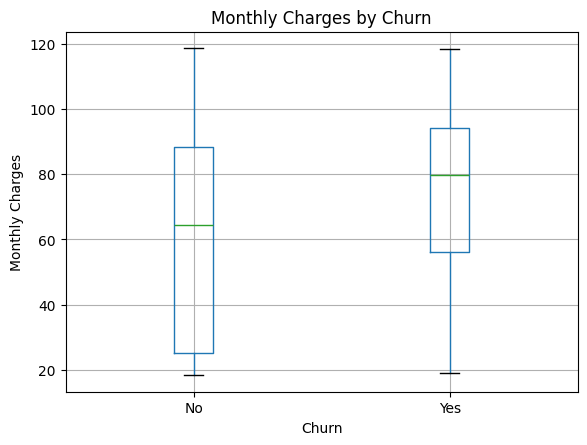

In [11]:
plt.figure(figsize=(6,4))
df.boxplot(column='MonthlyCharges', by='Churn')
plt.title("Monthly Charges by Churn")
plt.suptitle("")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.show()

(2) 누적 요금(TotalCharges) 분포 비교

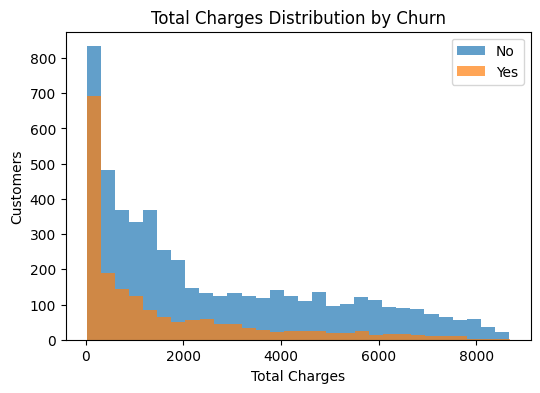

In [12]:
plt.figure(figsize=(6,4))
plt.hist(df[df['Churn']=='No']['TotalCharges'], bins=30, alpha=0.7, label='No')
plt.hist(df[df['Churn']=='Yes']['TotalCharges'], bins=30, alpha=0.7, label='Yes')
plt.legend()
plt.title("Total Charges Distribution by Churn")
plt.xlabel("Total Charges")
plt.ylabel("Customers")
plt.show()

**결과 해석**
- 이탈 고객은 유지 고객 대비 상대적으로 높은 월 요금과 낮은 누적 요금 구간에 분포함
- 이는 단기간 이용과 상대적으로 높은 비용 구조가 이탈과 연관될 가능성을 시사함
  
**한계**
- 해당 분포만으로는 비용 수준 자체가 이탈의 직접 원인인지, 계약·서비스 구조에 의해 형성된 결과인지 판단하기 어려움
- 따라서 비용 변수는 **서비스 구조 변수와의 결합 관점에서 해석할 필요**가 있으며, 이에 대한 검증은 이후 섹션에서 진행함

#### 4-3. 서비스 구조 변수: Contract / InternetService
- 시간과 비용 변수가 이탈의 결과라면, 서비스 구조 변수는 이탈을 유도하는 설계 조건으로 해석 가능
- 앞선 패턴이 발생한 구조적 배경을 설명하는 역할

(1) Contract 유형별 이탈률

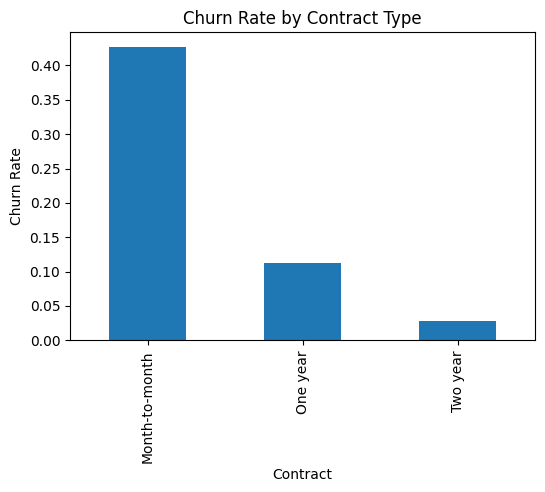

In [13]:
contract_churn = (
    df.groupby('Contract')['Churn']
      .value_counts(normalize=True)
      .unstack()
)

contract_churn['Yes'].plot(kind='bar', figsize=(6,4))
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Rate")
plt.show()

(2) InternetService 유형별 이탈률


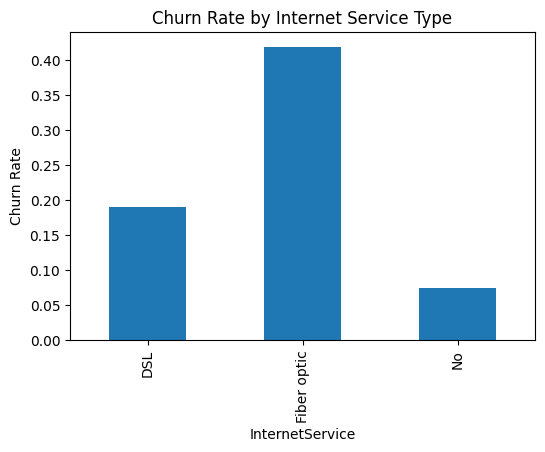

In [14]:
internet_churn = (
    df.groupby('InternetService')['Churn']
      .value_counts(normalize=True)
      .unstack()
)

internet_churn['Yes'].plot(kind='bar', figsize=(6,4))
plt.title("Churn Rate by Internet Service Type")
plt.ylabel("Churn Rate")
plt.show()

**결과 해석**
- Month-to-month 계약 고객의 이탈률이 가장 높음
- InternetService 중 Fiber optic 고객군에서 이탈률이 상대적으로 높음
- 서비스 구조 변수 단독 기준에서도 이탈 분포 차이가 명확하게 관찰됨  

-> 해당 변수들은 이후 조합 분석의 핵심 축으로 활용 가능

### 5. 변수 간 조합 분석
단변량 분석 결과,   
`tenure`, `Contract`, `InternetService`는 각각 이탈과의 연관성이 높게 관찰되었습니다.  

본 단계에서는 **변수 간 조합 효과를 통해**,  
**실질적인 고위험 고객 세그먼트**를 식별합니다.

#### 5-1. 분석 대상 조합
- InternetService = Fiber optic
    - 단변량 분석에서 이탈률이 가장 높게 나타난 서비스 유형
- Contract x Tenure Group
    - 시간 + 구조 요인의 결합 효과 확인

#### 5-2. 조합 기준 이탈률 테이블 생성
`tenure`는 비즈니스 해석을 용이하게 하기 위해 구간화(tenure_group)하여 사용했습니다.  

- 구간 정의: **좌측 포함 · 우측 미포함**
    - [0, 6), [6, 12), [12, 24), [24, ∞)
- 표기 라벨: 0-5개월, 6-11개월 등

In [15]:
def tenure_grouping(x):
    if x < 6:
        return "0-5개월"
    elif x < 12:
        return "6-11개월"
    elif x < 24:
        return "12-23개월"
    else:
        return "24개월 이상"

df["tenure_group"] = df["tenure"].apply(tenure_grouping)

In [16]:
final_table = (
    df[df["InternetService"] == "Fiber optic"]
    .groupby(["Contract", "tenure_group"])
    .agg(
        churn_rate=("Churn", lambda x: (x == "Yes").mean()),
        customer_cnt=("customerID", "count")
    )
    .reset_index()
)

final_table

,Contract,tenure_group,churn_rate,customer_cnt
0,Month-to-month,0-5개월,0.747826,575
1,Month-to-month,12-23개월,0.517401,431
2,Month-to-month,24개월 이상,0.390987,821
3,Month-to-month,6-11개월,0.624585,301
4,One year,0-5개월,1.000000,1
5,One year,12-23개월,0.200000,25
6,One year,24개월 이상,0.192157,510
7,One year,6-11개월,0.000000,3
8,Two year,24개월 이상,0.072261,429


**결과 해석**  
- Fiber optic 서비스를 이용하는 Month-to-month 계약 고객 중, **사용 기간 0–5개월 구간에서 이탈률이 가장 높게 나타남**
- 동일한 Fiber optic 고객이라도 **계약 기간이 길어질수록 이탈률은 급격히 감소**
- 장기 계약과 결합된 세그먼트는 고객 수는 많지만 **상대적으로 안정적**

### 6. 핵심 인사이트 및 액션 포인트
본 EDA를 통해 고객 이탈은 월 요금과 같은 단일 비용 변수로는 충분히 설명되지 않으며,  
**시간(tenure)·계약·서비스 구조 요인이 결합될 때 특정 세그먼트에서 집중적으로 나타남**을 확인했습니다.

#### 6-1. 주요 인사이트 요약
- 시간 요인 (Tenure)
    - 이탈 고객은 비이탈 고객 대비 현저히 짧은 사용 기간을 보임
    - 특히 0–5개월 구간에서 이탈이 집중
→ 신규 고객 초기 이탈 관리가 핵심

- 비용 요인 (Charges)
    - 이탈 고객은 월 요금이 상대적으로 높고, 누적 요금은 낮음
    - 단기간 사용 + 높은 비용 구조가 이탈과 밀접

- 서비스 구조 요인
    - Month-to-month 계약 고객의 이탈률이 가장 높음
    - Fiber optic 서비스 고객군에서 이탈률이 상대적으로 높게 관찰됨

- 변수 간 조합 효과
    - Fiber optic × Month-to-month × 0–5개월
        - 가장 높은 이탈률을 보이는 고위험 세그먼트
    - 동일 서비스라도 장기 계약으로 전환 시 이탈률이 급감

#### 6-2. 비즈니스 관점 액션
| 구분    | 제안 액션                       |
| ----- | --------------------------- |
| 신규 고객 | 가입 초기(0–3개월) 이탈 감지 로직 강화    |
| 요금 구조 | 고월요금 고객 대상 할인·번들 제안         |
| 계약 전략 | Month-to-month 고객의 장기 계약 유도 |
| 타깃 관리 | Fiber optic 신규 고객군 집중 관리    |  
  
본 EDA에서는 고객 이탈에 영향을 미치는 주요 변수와  
이탈 위험이 상대적으로 높게 관찰되는 세그먼트를 탐색적으로 식별했습니다.

본 EDA에서 식별한 변수 및 세그먼트는  
이후 **SQL 기반 KPI 분석에서 운영 DB 기준으로 재정의·검증**됩니다.

최종적으로, 본 EDA에서 도출된 주요 변수 및 세그먼트는  
**Streamlit 대시보드에서 KPI 모니터링 및 필터링 기준**으로 활용됩니다.

**본 EDA에서 사용한 전처리 완료 데이터는 분석-모델링 간 데이터 일관성 유지를 위해 별도 파일로 저장하였습니다.**  
**해당 데이터는 동일한 전처리 기준을 기반으로 이후 예측 모델 학습에 활용됩니다.**

In [17]:
df.to_csv("../data/cleaned_churn.csv", index=False)